# Setup imports 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('..')
from functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters, simpleaxis
from oasis import oasisAR1, oasisAR2

In [3]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
    plt.ylim(0,1.3)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    simpleaxis(plt.gca())
    print "Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1]
    print "Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1]

# Load raw fluorescence data 
This data happend to have a fast rise time and we model it with an AR(1) process, see below for slower rise time and AR(2).

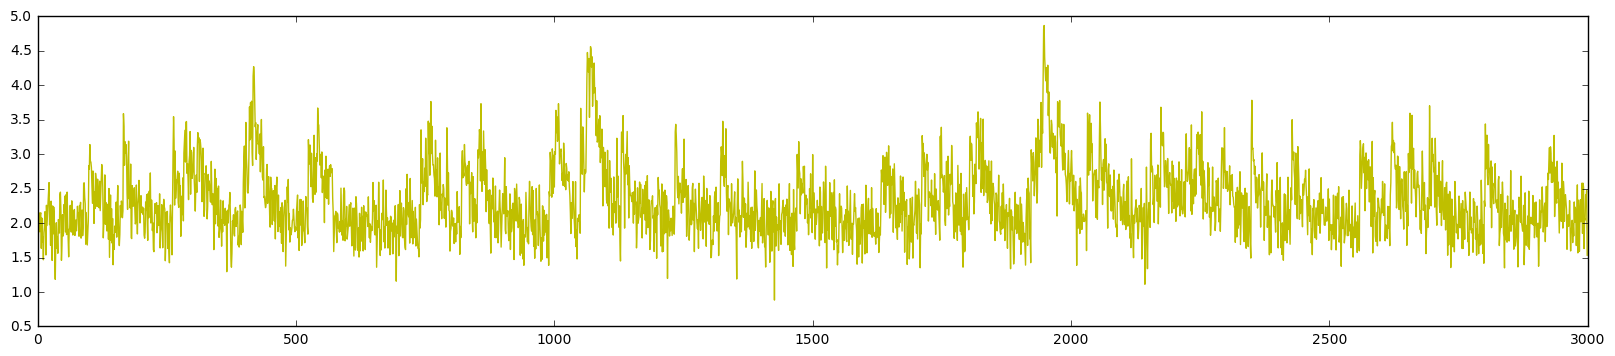

In [4]:
# here we generate some simulated fluorescence data and plot it
true_b = 2
y, true_c, true_s = map(np.squeeze, gen_data(N=1, b=true_b, seed=0))
plt.figure(figsize=(20,4))
plt.plot(y, c='y');

# Deconvolve 

### With $\ell_1$ penalty we obtain the global minimum of the convex problem 
If we only have the trace and no further info, simply calling deconvolve tries to estimate it from the data 

In [5]:
%time c, s, b, g, lam = deconvolve(y, penalty=1)

CPU times: user 13.6 ms, sys: 1.31 ms, total: 14.9 ms
Wall time: 14.4 ms


#### Plot results
Because we happen to have ground truth data, we show it too 

Correlation of deconvolved activity  with ground truth ('spikes') : 0.8924
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9790


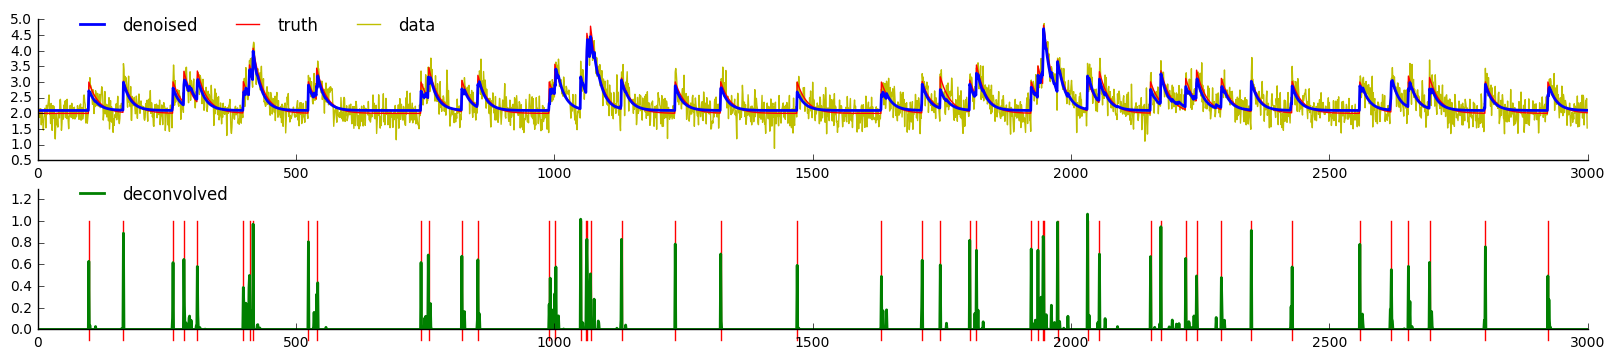

In [6]:
plot_trace(True)

### With $\ell_0$ penalty the problem is non-convex, however, we obtain a good local minimum

CPU times: user 15.1 ms, sys: 1.91 ms, total: 17.0 ms
Wall time: 15.2 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.9179
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9825


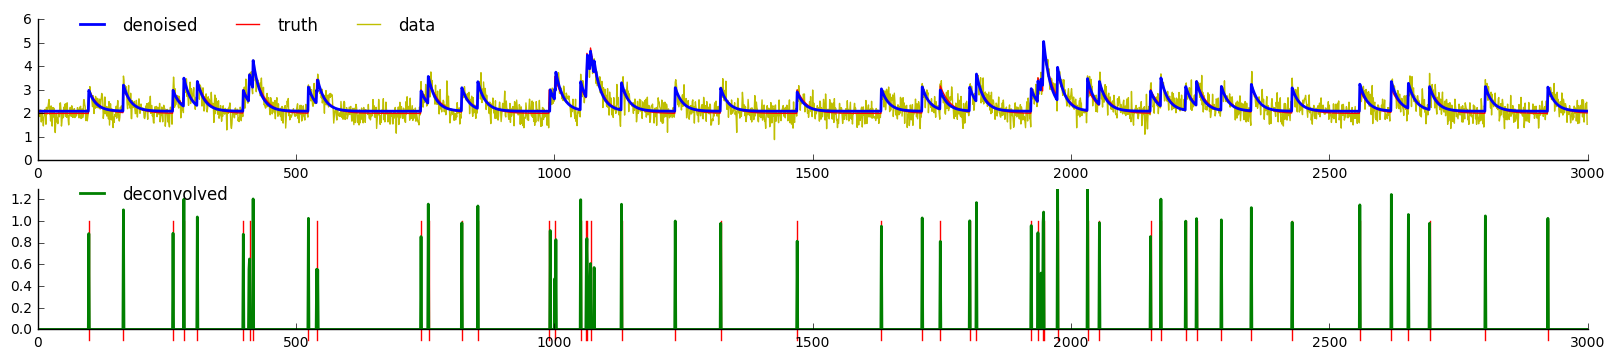

In [7]:
%time c, s, b, g, lam = deconvolve(y, penalty=0)
plot_trace(True)

### If we have a good idea about the fluorescence baseline, its time constant and it size for 1AP, we can provide this information
$g$ is related to the decay time $\tau_d$ of the exponetial Ca response kernel $e^{-t/\tau_d}$ as $g=e^{-\frac{1}{\tau_d r}}$ with decay time $\tau_d$ in seconds and imaging rate r in Hz.

CPU times: user 3.5 ms, sys: 430 µs, total: 3.93 ms
Wall time: 3.63 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.9120
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9894


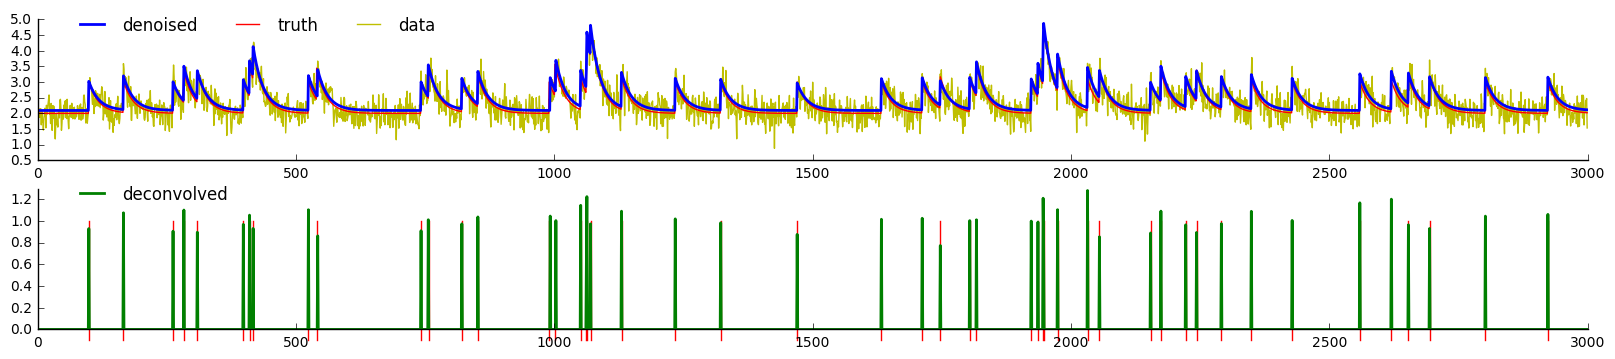

In [8]:
# Here we provide the ground truth values for b and g. 
# The Ca response kernel to 1 AP has maximal amplitude 1 and we pick s_min slightly larger than 1/2.
%time c, s = oasisAR1(y-true_b, g=.95, s_min=.55)
plot_trace(True)

### If $g$ is not provided, it is estimated from the autocorrelation. We can improve upon it, in particularly if the spiking signal has some significant autocorrelation.
In function deconvolve, we already multiply the autocorrelation estimate by some fudge_factor that is close to but smaller than 1, which increases robustness

CPU times: user 83.5 ms, sys: 2.04 ms, total: 85.6 ms
Wall time: 78.4 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.8226
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9923


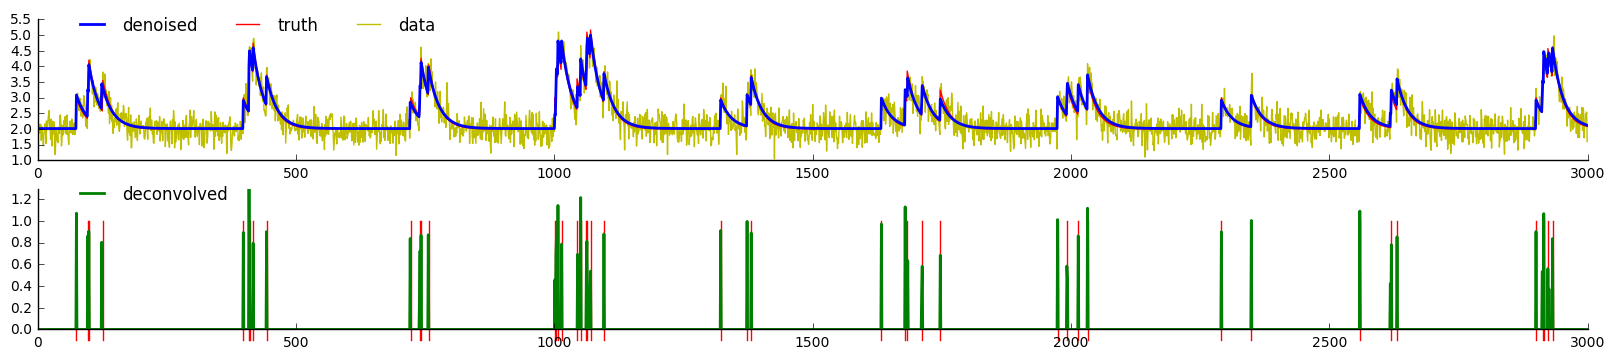

In [9]:
# no optimization of g
y, true_c, true_s = map(np.squeeze, gen_sinusoidal_data(N=1, b=true_b, seed=0))
%time c, s, b, g, lam = deconvolve(y, penalty=0)
# the line below uses the direct autocorrelation estimate without fudge_factor, yielding worse results
# %time c, s, b, g, lam = deconvolve(y, g=estimate_parameters(y, 1)[0], penalty=0) 
plot_trace(True)

CPU times: user 41.7 ms, sys: 2.03 ms, total: 43.8 ms
Wall time: 26.8 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.8522
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9922


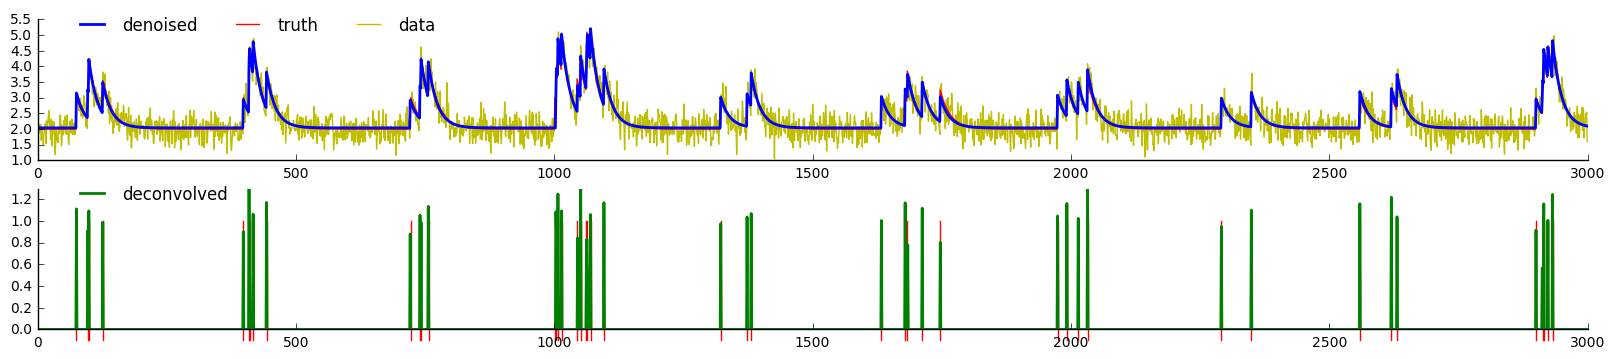

In [10]:
# optimization of g. optimize_g=5 uses 5 large isolated calcium events to update g.
%time c, s, b, g, lam = deconvolve(y, penalty=0, optimize_g=5)
plot_trace(True)

# Load some other raw fluorescence data 
This data happend to have a slow rise time and we model it with an AR(2) process

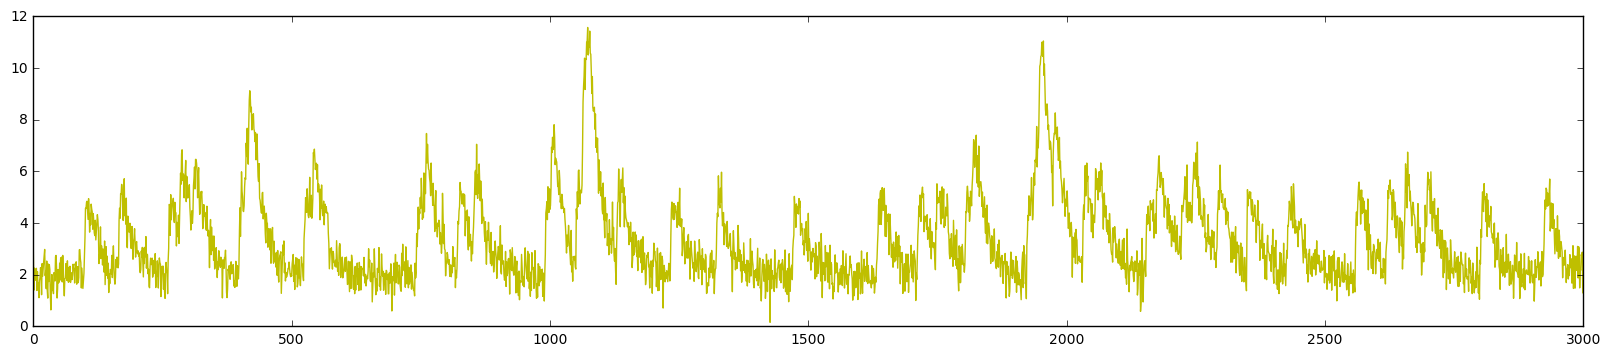

In [11]:
# here we generate some simulated fluorescence data and plot it
y, true_c, true_s = map(np.squeeze, gen_data([1.7,-.712], sn=.5, N=1, b=true_b, seed=0))
plt.figure(figsize=(20,4))
plt.plot(y, c='y');

# Deconvolve 

### With $\ell_1$ penalty we obtain the global minimum of the convex problem 
If we only have the trace and no further info, simply calling deconvolve tries to estimate it from the data 

CPU times: user 74.7 ms, sys: 2.24 ms, total: 76.9 ms
Wall time: 44.8 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.6434
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9947


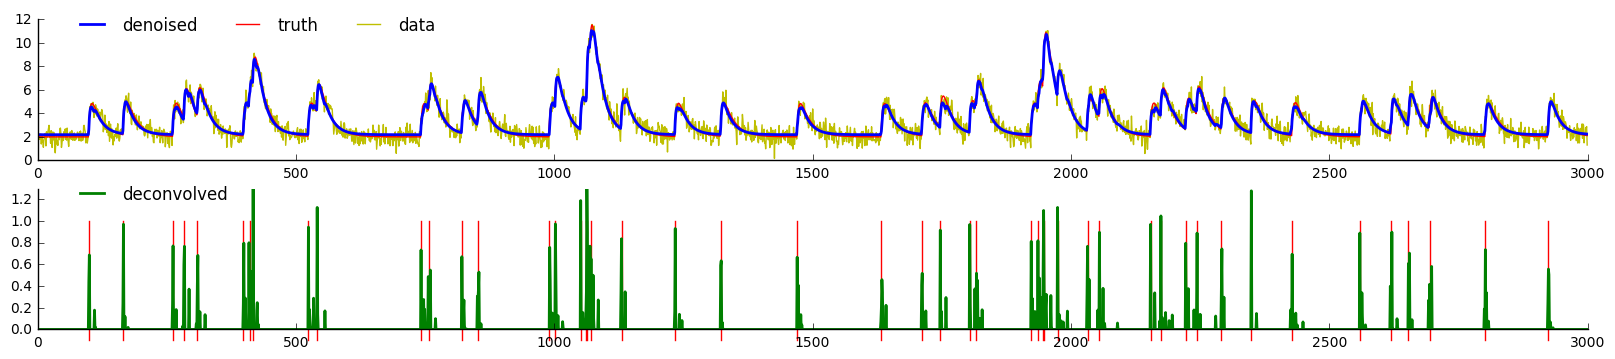

In [12]:
# g=(None,None) because we want to use an AR(2) model, but don't know the parameters
%time c, s, b, g, lam = deconvolve(y, g=(None,None), penalty=1) 
plot_trace(True)

### With $\ell_0$ penalty the problem is non-convex, however, we obtain a good local minimum

CPU times: user 105 ms, sys: 2.2 ms, total: 108 ms
Wall time: 60.3 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.6392
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9937


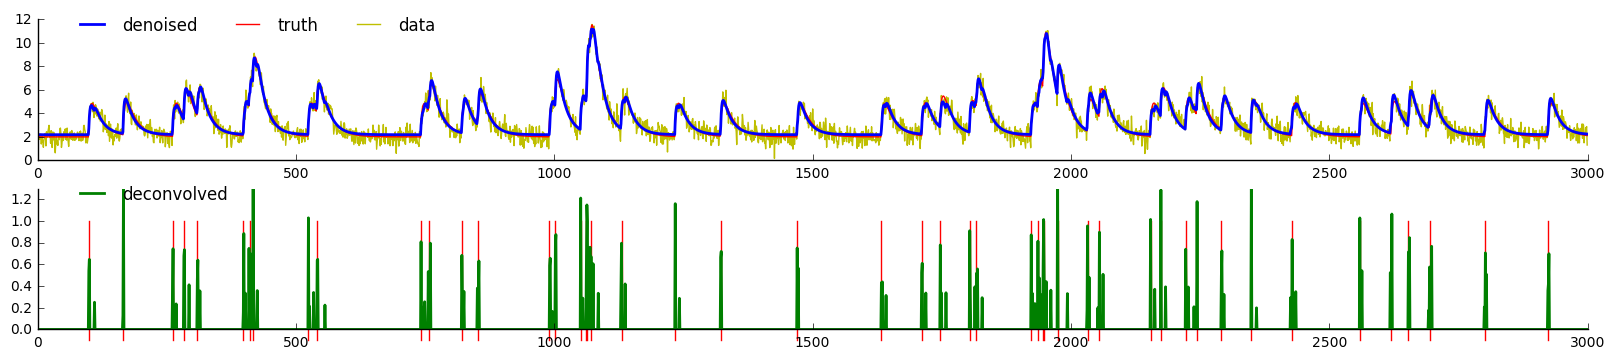

In [13]:
%time c, s, b, g, lam = deconvolve(y, g=(None,None), penalty=0)
plot_trace(True)

### We might further improve upon the initial estimate of $g$

../functions.py:185: UserWarning: Optimization of AR parameters is already fairly stable for AR(1), but slower and more experimental for AR(2)
  warn("Optimization of AR parameters is already fairly stable for AR(1), "


CPU times: user 1.84 s, sys: 22.9 ms, total: 1.86 s
Wall time: 993 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.7667
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9969


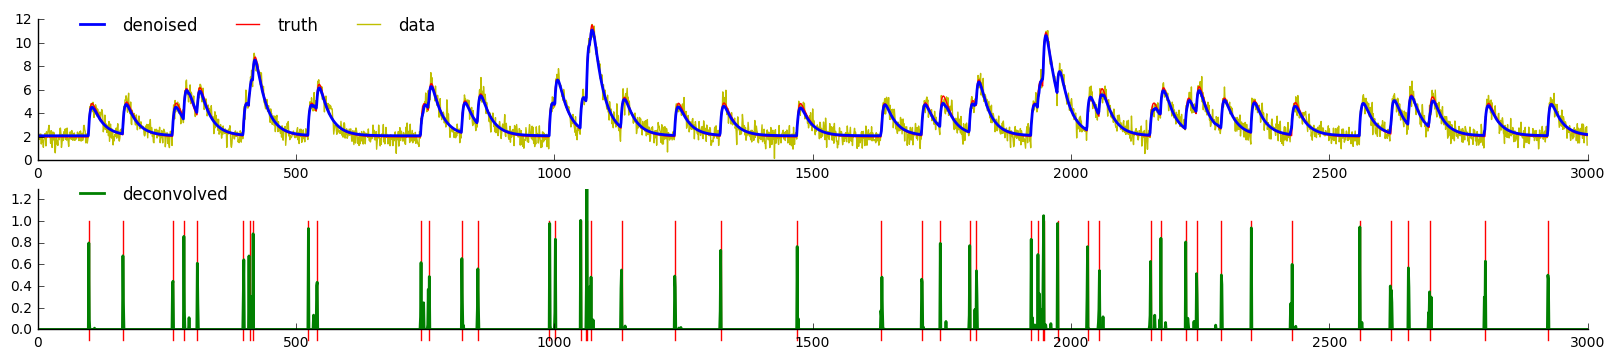

In [14]:
# this is currently slow, we hope to still improve speed as well as robustness
%time c, s, b, g, lam = deconvolve(y, g=(None,None), penalty=0, optimize_g=5, max_iter=5) 
plot_trace(True)

### If we have a good idea about the fluorescence baseline, and its time constants we can provide this information
$g=(g_1,g_2)$ is related to the decay time $\tau_d$ and rise time $\tau_r$ (in seconds) of the Ca response kernel $e^{-t/\tau_d}-e^{-t/\tau_r}$ as <br>
$g_1=e^{-\frac{1}{\tau_d r}}+e^{-\frac{1}{\tau_r r}}$ and <br>
$g_2=-e^{-\frac{1}{\tau_d r}}\cdot e^{-\frac{1}{\tau_r r}}$ with imaging rate r in Hz.

CPU times: user 70.4 ms, sys: 1.63 ms, total: 72.1 ms
Wall time: 42.1 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.7765
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9968


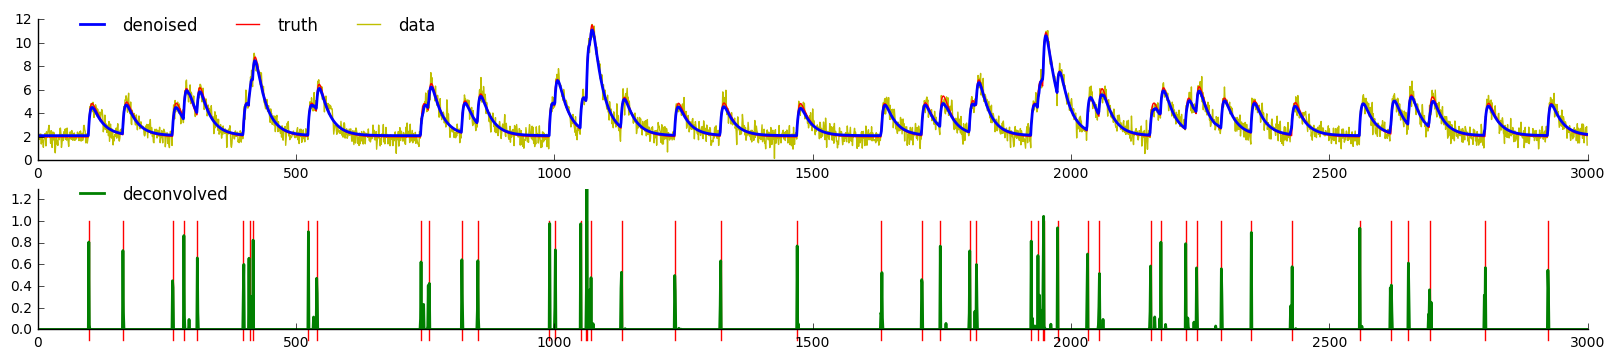

In [15]:
# Here we provide the ground truth values for g. 
%time c, s, b, g, lam = deconvolve(y, (1.7,-.712))
plot_trace(True)

#### We can also opt for a quick but less accurate greedy method 

CPU times: user 13.1 ms, sys: 1.41 ms, total: 14.5 ms
Wall time: 13.3 ms
Correlation of deconvolved activity  with ground truth ('spikes') : 0.7199
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9973


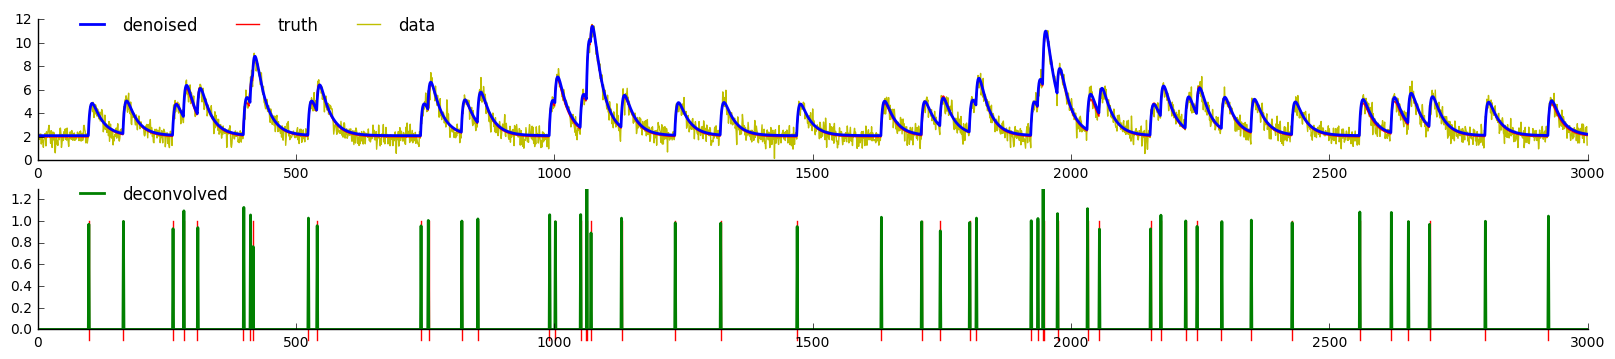

In [16]:
# Here we provide the ground truth values for b and g and we pick s_min slightly larger than 1/2.
%time c, s = oasisAR2(y-true_b, 1.7,-.712, s_min=.55)
plot_trace(True)